## Time series prediction. Selection of hyperparameters by differential evolution method and simplex method

The data is a set of historical data of the Moscow Exchange RCMX ETF fund. The task is to predict the value of the fund for the next 14 days

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
from scipy import stats
import seaborn as sns
import os
from prophet import Prophet
import holidays
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 14})

Importing plotly failed. Interactive plots will not work.


## Reading data and data preparation

In [3]:
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%d.%m.%Y')

In [4]:
df_full = pd.read_csv('RCMX.csv', parse_dates=['date'], date_parser=dateparse, names=['date', 'price', 'price_open', 'price_max', 'price_min', 'vol', 'change_perc'], skiprows=1, thousands = '.',decimal=",")
df_full.head()

C:\Users\User\AppData\Local\Temp\ipykernel_21016\2960974547.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_full = pd.read_csv('RCMX.csv', parse_dates=['date'], date_parser=dateparse, names=['date', 'price', 'price_open', 'price_max', 'price_min', 'vol', 'change_perc'], skiprows=1, thousands = '.',decimal=",")


,date,price,price_open,price_max,price_min,vol,change_perc
0,2023-08-18,1267.0,1255.0,1278.0,1255.0,"2,69K","-0,08%"
1,2023-08-17,1268.0,1271.5,1289.0,1256.5,"37,99K","0,20%"
2,2023-08-16,1265.5,1274.5,1299.5,1242.5,"11,82K","-2,62%"
3,2023-08-15,1299.5,1299.0,1322.5,1276.0,"7,47K","0,70%"
4,2023-08-14,1290.5,1269.0,1344.0,1268.5,"6,54K","-1,83%"


In [5]:
df = df_full[['date', 'price']]
new_date = pd.to_datetime(df['date'],  format='%d.%m.%Y')
df['date'] = new_date
df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_21016\764369902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = new_date


,date,price
0,2023-08-18,1267.0
1,2023-08-17,1268.0
2,2023-08-16,1265.5
3,2023-08-15,1299.5
4,2023-08-14,1290.5


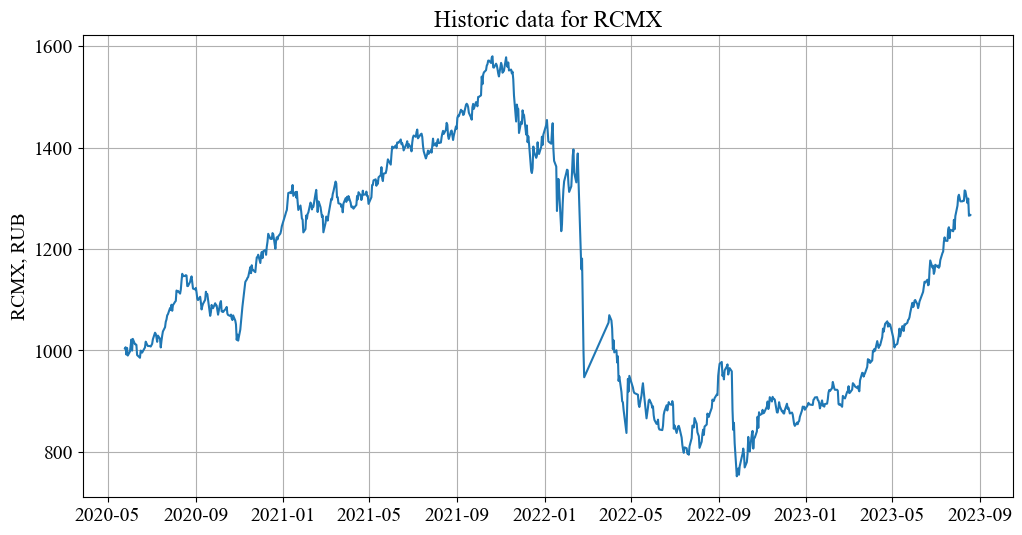

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df.date, df.price)
plt.ylabel('RCMX, RUB')
plt.title('Historic data for RCMX')
plt.grid()

In [7]:
from datetime import datetime
import datetime 

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [8]:
dfn = df.set_index('date').resample('D').asfreq()

dfn['Day'] = dfn.index.strftime('%A')

cond = dfn['Day'].isin(['Saturday', 'Sunday'])
dfn = dfn[~cond].fillna(method='ffill').reset_index()

df = dfn.sort_values('date', ascending=False).reset_index(drop=True)

C:\Users\User\AppData\Local\Temp\ipykernel_21016\3274750613.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfn = dfn[~cond].fillna(method='ffill').reset_index()


### Number of days for forecasting

In [9]:
amount_of_predicted_days = 14

## Split on test и train sets

In [10]:
df_test = df[:amount_of_predicted_days][['date', 'price']].rename(columns={'date':'ds','price':'y'})
df_train = df[amount_of_predicted_days:amount_of_predicted_days*10][['date', 'price']].rename(columns={'date':'ds','price':'y'})

In [11]:
df_for_comparison = pd.concat([df_train, df_test]).sort_values('ds').reset_index(drop=True)
df_for_comparison.head()

,ds,y
0,2023-02-06,926.0
1,2023-02-07,938.0
2,2023-02-08,932.0
3,2023-02-09,925.5
4,2023-02-10,922.5


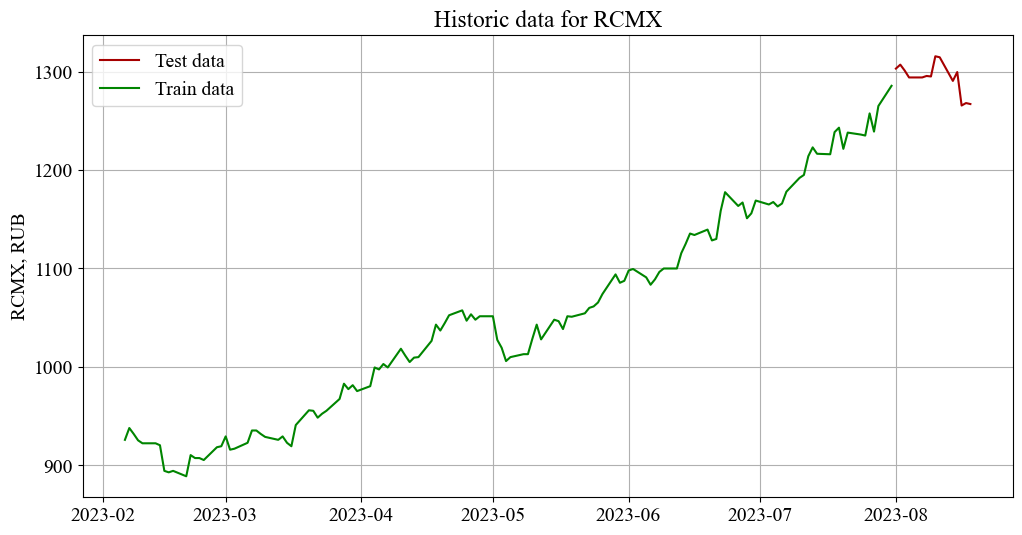

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df_test.ds, df_test.y, label='Test data', color='#A60000')
plt.plot(df_train.ds, df_train.y, label='Train data', color='#008500')
plt.ylabel('RCMX, RUB')
plt.title('Historic data for RCMX')
plt.legend()
plt.grid()

## Add holidays in the model

In [13]:
holidays_dict = holidays.RUS(years=(2022,2023,2024))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
39,2024-03-08,Международный женский день
40,2024-05-01,Праздник Весны и Труда
41,2024-05-09,День Победы
42,2024-06-12,День России
43,2024-11-04,День народного единства


## Example of model with random parameters

In [14]:
m = Prophet(holidays=df_holidays,
            changepoint_range=0.95,
            seasonality_prior_scale=10,
            changepoint_prior_scale=0.5).fit(df_train)

In [16]:
future = m.make_future_dataframe(periods=amount_of_predicted_days+4, freq='D') 

In [17]:
forecast = m.predict(future)

In [18]:
cmp_df = forecast[['ds','yhat_lower', 'yhat_upper', 'yhat']] \
.join(df_for_comparison.set_index('ds'), on='ds', how='inner')
cmp_df = cmp_df.round(2)
cmp_df.head()

,ds,yhat_lower,yhat_upper,yhat,y
0,2023-02-06,925.94,944.46,935.15,926.0
1,2023-02-07,924.51,942.93,933.67,938.0
2,2023-02-08,918.18,935.72,927.35,932.0
3,2023-02-09,916.30,933.94,924.89,925.5
4,2023-02-10,915.69,933.53,924.32,922.5


In [19]:
cmp_df['ae'] = abs(cmp_df['y'] - cmp_df['yhat'])
cmp_df['ape'] = 100*cmp_df['ae']/cmp_df['y']
cmp_df['se'] = (cmp_df['y'] - cmp_df['yhat'])**2

In [20]:
cmp_df.tail()

,ds,yhat_lower,yhat_upper,yhat,y,ae,ape,se
139,2023-08-14,1282.91,1367.13,1321.25,1290.5,30.75,2.382797,945.5625
140,2023-08-15,1281.87,1377.79,1326.33,1299.5,26.83,2.064640,719.8489
141,2023-08-16,1276.05,1381.82,1326.56,1265.5,61.06,4.824970,3728.3236
142,2023-08-17,1275.26,1392.70,1330.65,1268.0,62.65,4.940852,3925.0225
143,2023-08-18,1275.42,1405.01,1336.64,1267.0,69.64,5.496448,4849.7296


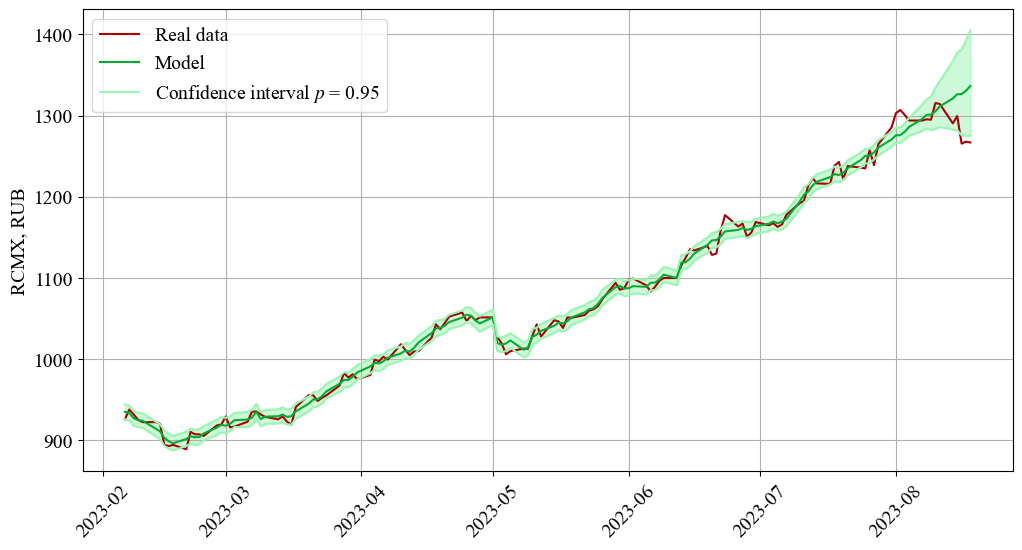

In [21]:
plt.figure(figsize=(12,6))
plt.plot(cmp_df.ds,cmp_df.y, label = 'Real data', color='#A80005')
plt.plot(cmp_df.ds,cmp_df.yhat, label = 'Model', color='#00AD2F')
plt.plot(cmp_df.ds,cmp_df.yhat_lower, 
label = 'Confidence interval $p$ = 0.95', color='#9CF5B3')
plt.plot(cmp_df.ds,cmp_df.yhat_upper, color='#9CF5B3')
plt.fill_between(cmp_df.ds,cmp_df.yhat_lower,
cmp_df.yhat_upper, color='#9CF5B3',alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('RCMX, RUB')
plt.legend()
plt.grid()

## Selection of model hyperparameters by differential evolution and simplex methods

In [22]:
mins = np.array([0.8, 0.01, 0.001])
maxes = np.array([0.95, 10, 0.5])

# https://facebook.github.io/prophet/docs/diagnostics.html

def denormalize(x):
    return mins + x*(maxes-mins)

def normalize(x):
    return (x - mins) / (maxes-mins)

def minimize_foo_evol(x):
    point = denormalize(x)
    X = [0,0,0]
    X[0], X[1], X[2] = point
    try:
        m = Prophet(changepoint_range=X[0],
                    seasonality_prior_scale=X[1],
                    changepoint_prior_scale=X[2]).fit(df_train)

        future = m.make_future_dataframe(periods=amount_of_predicted_days, freq='D')
        forecast = m.predict(future)
        
        cmp_df = forecast[['ds','yhat_lower', 'yhat_upper', 'yhat']].join(df_for_comparison.set_index('ds'), on='ds', how='inner')
        cmp_df = cmp_df.round(2)
        cmp_df['ae'] = abs(cmp_df['y'] - cmp_df['yhat'])
        cmp_df['ape'] = 100*cmp_df['ae']/cmp_df['y']
        cmp_df['se'] = (cmp_df['y'] - cmp_df['yhat'])**2
        
        crit = np.mean(abs(cmp_df[-amount_of_predicted_days:]['ape'])) # критерий оптимизации

    except:
        crit = np.nan
    return crit

In [23]:
from scipy.optimize import differential_evolution

In [24]:
bounds = [(0,1), (0,1), (0,1)]

### Optimization by non-gradient method

In [25]:
result_from_diff_evo = differential_evolution(minimize_foo_evol, bounds=bounds, 
                       args=(), strategy='best1exp', maxiter=35, 
                       popsize=13, tol=0.05, mutation=(0.4, 1.1), 
                       recombination=0.7, seed=None, 
                       disp=True, polish=False)

differential_evolution step 1: f(x)= 0.992235
differential_evolution step 2: f(x)= 0.991383


In [26]:
result_from_diff_evo, denormalize(result_from_diff_evo.x)

( message: Optimization terminated successfully.
  success: True
      fun: 0.9913832699204148
        x: [ 3.959e-01  9.222e-01  2.688e-01]
      nit: 2
     nfev: 117,
 array([0.85938269, 9.22325574, 0.13512157]))

### Optimization by gradient method, with initial conditions after differential evolution

In [27]:
result = minimize(minimize_foo_evol, x0=denormalize(result_from_diff_evo.x), args=(), method='Nelder-Mead', bounds=bounds,
                                options={'maxiter':500, 'disp':True})

C:\Users\User\AppData\Local\Temp\ipykernel_21016\2468652457.py:1: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(minimize_foo_evol, x0=denormalize(result_from_diff_evo.x), args=(), method='Nelder-Mead', bounds=bounds,


Optimization terminated successfully.
         Current function value: 1.014472
         Iterations: 118
         Function evaluations: 330


In [28]:
result, denormalize(result.x)

(       message: Optimization terminated successfully.
        success: True
         status: 0
            fun: 1.0144721343632308
              x: [ 8.642e-01  1.000e+00  1.490e-01]
            nit: 118
           nfev: 330
  final_simplex: (array([[ 8.642e-01,  1.000e+00,  1.490e-01],
                        [ 8.642e-01,  1.000e+00,  1.490e-01],
                        [ 8.642e-01,  1.000e+00,  1.490e-01],
                        [ 8.642e-01,  1.000e+00,  1.490e-01]]), array([ 1.014e+00,  1.014e+00,  1.014e+00,  1.014e+00])),
 array([ 0.92962677, 10.        ,  0.07533045]))

In [29]:
if result_from_diff_evo.fun >= result.fun:
    best_features = denormalize(result.x)
else:
    best_features = denormalize(result_from_diff_evo.x)
best_features

array([0.85938269, 9.22325574, 0.13512157])

In [30]:
m = Prophet(
changepoint_range=best_features[0],
seasonality_prior_scale=best_features[1],
changepoint_prior_scale=best_features[2]
).fit(df_for_comparison)

In [31]:
future = m.make_future_dataframe(periods=amount_of_predicted_days, freq='D')
forecast = m.predict(future)

In [32]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-02-06,925.816013,910.862237,942.928149,925.816013,925.816013,1.491098,1.491098,1.491098,1.491098,1.491098,1.491098,0.0,0.0,0.0,927.307110
1,2023-02-07,924.125718,910.700744,943.283151,924.125718,924.125718,3.401780,3.401780,3.401780,3.401780,3.401780,3.401780,0.0,0.0,0.0,927.527498
2,2023-02-08,922.435423,906.164762,938.923949,922.435423,922.435423,0.100237,0.100237,0.100237,0.100237,0.100237,0.100237,0.0,0.0,0.0,922.535660
3,2023-02-09,920.745128,905.258708,937.108617,920.745128,920.745128,0.306857,0.306857,0.306857,0.306857,0.306857,0.306857,0.0,0.0,0.0,921.051986
4,2023-02-10,919.054833,906.079475,937.098464,919.054833,919.054833,1.673436,1.673436,1.673436,1.673436,1.673436,1.673436,0.0,0.0,0.0,920.728269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2023-08-28,1326.066836,1309.704342,1345.054095,1320.215562,1332.365303,1.491098,1.491098,1.491098,1.491098,1.491098,1.491098,0.0,0.0,0.0,1327.557934
150,2023-08-29,1328.217084,1313.343145,1350.232659,1321.248502,1335.343279,3.401780,3.401780,3.401780,3.401780,3.401780,3.401780,0.0,0.0,0.0,1331.618864
151,2023-08-30,1330.367332,1311.554557,1348.103370,1322.546346,1338.801666,0.100237,0.100237,0.100237,0.100237,0.100237,0.100237,0.0,0.0,0.0,1330.467569
152,2023-08-31,1332.517579,1312.881241,1352.482274,1323.429208,1342.185043,0.306857,0.306857,0.306857,0.306857,0.306857,0.306857,0.0,0.0,0.0,1332.824437


In [33]:
cmp_df = forecast[['ds','yhat_lower', 'yhat_upper', 'yhat']].join(df_for_comparison.set_index('ds'), on='ds', how='outer')
cmp_df = cmp_df.round(2)
cmp_df.tail(7)

,ds,yhat_lower,yhat_upper,yhat,y
147,2023-08-26,1301.24,1335.34,1318.28,NaN
148,2023-08-27,1302.02,1336.83,1320.43,NaN
149,2023-08-28,1309.70,1345.05,1327.56,NaN
150,2023-08-29,1313.34,1350.23,1331.62,NaN
151,2023-08-30,1311.55,1348.10,1330.47,NaN
152,2023-08-31,1312.88,1352.48,1332.82,NaN
153,2023-09-01,1317.34,1357.67,1336.34,NaN


In [34]:
cmp_df

,ds,yhat_lower,yhat_upper,yhat,y
0,2023-02-06,910.86,942.93,927.31,926.0
1,2023-02-07,910.70,943.28,927.53,938.0
2,2023-02-08,906.16,938.92,922.54,932.0
3,2023-02-09,905.26,937.11,921.05,925.5
4,2023-02-10,906.08,937.10,920.73,922.5
...,...,...,...,...,...
149,2023-08-28,1309.70,1345.05,1327.56,NaN
150,2023-08-29,1313.34,1350.23,1331.62,NaN
151,2023-08-30,1311.55,1348.10,1330.47,NaN
152,2023-08-31,1312.88,1352.48,1332.82,NaN


In [35]:
dfn = cmp_df.set_index('ds').resample('D').asfreq()

dfn['Day'] = dfn.index.strftime('%A')

cond = dfn['Day'].isin(['Saturday', 'Sunday'])
dfn = dfn[~cond].fillna(method='ffill').reset_index()

cmp_df = dfn.sort_values('ds', ascending=True).reset_index(drop=True)

C:\Users\User\AppData\Local\Temp\ipykernel_21016\1797542872.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfn = dfn[~cond].fillna(method='ffill').reset_index()


In [36]:
cmp_df[-(amount_of_predicted_days)+4:]

,ds,yhat_lower,yhat_upper,yhat,y,Day
140,2023-08-21,1296.01,1328.97,1312.51,1267.0,Monday
141,2023-08-22,1300.42,1332.45,1316.57,1267.0,Tuesday
142,2023-08-23,1299.76,1332.35,1315.42,1267.0,Wednesday
143,2023-08-24,1301.89,1334.45,1317.77,1267.0,Thursday
144,2023-08-25,1304.02,1337.52,1321.29,1267.0,Friday
145,2023-08-28,1309.70,1345.05,1327.56,1267.0,Monday
146,2023-08-29,1313.34,1350.23,1331.62,1267.0,Tuesday
147,2023-08-30,1311.55,1348.10,1330.47,1267.0,Wednesday
148,2023-08-31,1312.88,1352.48,1332.82,1267.0,Thursday
149,2023-09-01,1317.34,1357.67,1336.34,1267.0,Friday


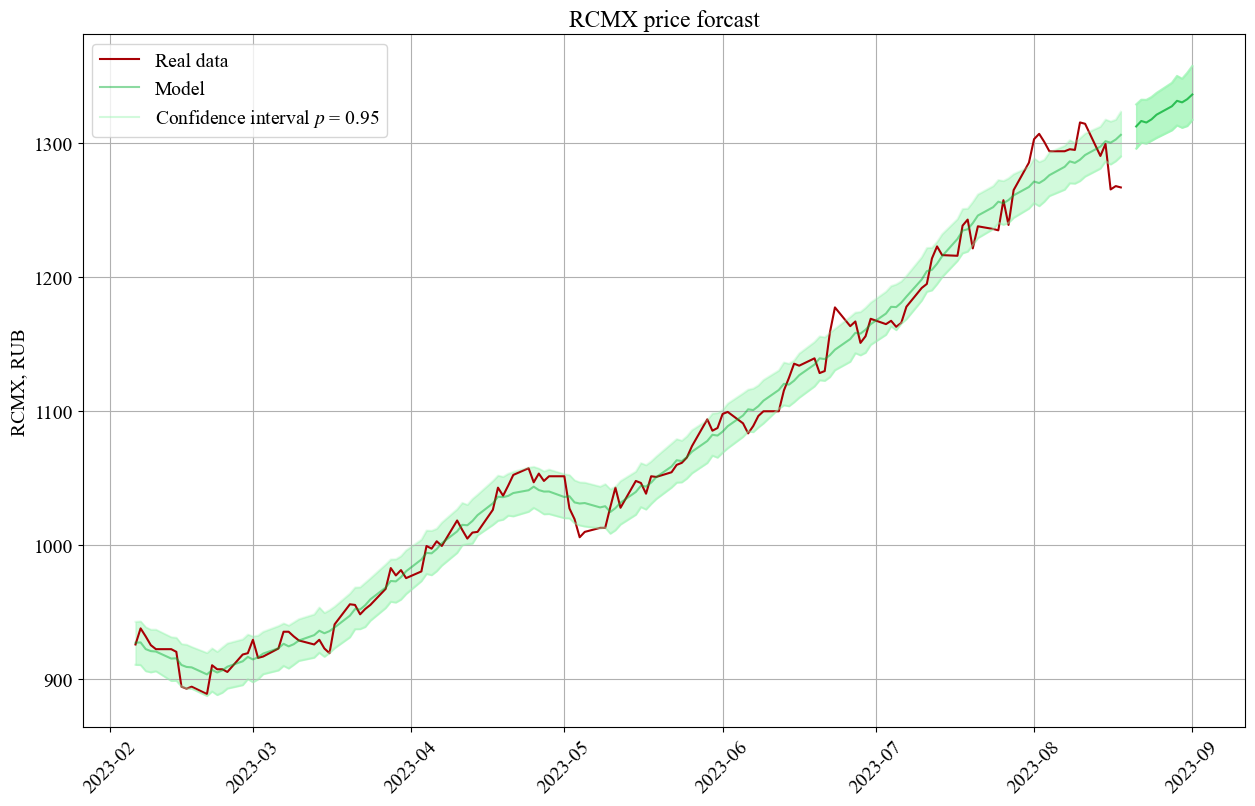

In [37]:
plt.figure(figsize=(15,9))

# фактические
plt.plot(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].y, 
         label = 'Real data', color='#A80005')

# модель и фактические
plt.plot(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].yhat, 
         label = 'Model', color='#00AD2F',alpha=0.45)

plt.plot(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].yhat_lower, 
        label = 'Confidence interval $p$ = 0.95', color='#9CF5B3',alpha=0.45)
plt.plot(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].yhat_upper, color='#9CF5B3', alpha=0.25)

plt.fill_between(cmp_df[:-amount_of_predicted_days+4].ds,cmp_df[:-amount_of_predicted_days+4].yhat_lower,
        cmp_df[:-amount_of_predicted_days+4].yhat_upper, color='#9CF5B3',alpha=0.45)

# модель прогноз
plt.plot(cmp_df[-(amount_of_predicted_days)+4:].ds,cmp_df[-(amount_of_predicted_days)+4:].yhat, 
         color='#00AD2F',alpha=0.75)

plt.plot(cmp_df[-(amount_of_predicted_days)+4:].ds,cmp_df[-(amount_of_predicted_days)+4:].yhat_lower, 
        color='#9CF5B3',alpha=0.75)
plt.plot(cmp_df[-(amount_of_predicted_days)+4:].ds,cmp_df[-(amount_of_predicted_days)+4:].yhat_upper, color='#9CF5B3',alpha=0.75)

plt.fill_between(cmp_df[-(amount_of_predicted_days)+4:].ds,cmp_df[-(amount_of_predicted_days)+4:].yhat_lower,
        cmp_df[-(amount_of_predicted_days)+4:].yhat_upper, color='#9CF5B3',alpha=0.75)

plt.xticks(rotation=45)
plt.ylabel('RCMX, RUB')
plt.title('RCMX price forcast')
plt.legend()
plt.grid()

### Forecasted RCMX price

In [38]:
cmp_df[-(amount_of_predicted_days)+4:].drop(columns=['y'])\
.rename(columns={'ds':'date', 'yhat_lower':'price_low', 'yhat_upper':'price_high', 'yhat':'price', 'Day':'day_name'})\
.reset_index(drop=True)

,date,price_low,price_high,price,day_name
0,2023-08-21,1296.01,1328.97,1312.51,Monday
1,2023-08-22,1300.42,1332.45,1316.57,Tuesday
2,2023-08-23,1299.76,1332.35,1315.42,Wednesday
3,2023-08-24,1301.89,1334.45,1317.77,Thursday
4,2023-08-25,1304.02,1337.52,1321.29,Friday
5,2023-08-28,1309.70,1345.05,1327.56,Monday
6,2023-08-29,1313.34,1350.23,1331.62,Tuesday
7,2023-08-30,1311.55,1348.10,1330.47,Wednesday
8,2023-08-31,1312.88,1352.48,1332.82,Thursday
9,2023-09-01,1317.34,1357.67,1336.34,Friday
